# ECE 364 Lecture 21
## Deep Nets (Part 3): Convolutional Neural Networks (Part 2)
### Learning Objectives
After this lecture, students will be able to
* Understand how fully convolutional networks (FCN) remove the need for fully-connected layers and enable richer machine learning problems than ordinary image classification or regression.
* Give examples of valid image augmentations for training CNNs.
* Explain the role of image augmentaitons, batch norm, and dropout in training CNNs.

## Recap of Convolutional Neural Networks (CNN)
Last lecture, we introduced convolutional neural networks (CNNs) as another common deep learning model that provides two key innovations on the multi-layer perceptron (MLP) model.
1. The number of parameters in CNNs do not scale with the size of the input. For example, the input layer of an MLP must have a width matching the number of pixels in an image. Clearly, this will become computationally prohibitive for very large images. Furthermore, this stipulates that our model take fixed-size inputs.
2. The use of convolution operators, as opposed to fully connected weight matrices in MLPs, provides spatial coherence to features learned by the deep learning model. These spatially meaningful features may be shifted or translated about an image with no change in identifying such a feature. Conversely, an MLP may learn such a feature or pattern, but in a rigid, fixed position within the input.

We discussed a couple new types of layers when introducing CNNs. Let's briefly review these layers.
### Convolutional Layers
A convolutional layer performs a convolution between an input image or collection of feature maps (i.e. intermediate features from a previous convolution layer) using convolution kernels that each generate one new feature map. The size of this feature map is determined by several details mentioned in the previous lecture and copied below. Each convolutional layer may have many convolution kernels and thus produce many feature maps. For example, the first layer of a CNN may take RGB images and thus have 3 input channels. One single $K\times K$ kernel will have three independent channels and thus be shape $3\times K\times K$. We may have some larger number of kernels learned at the layer $d$; thus, this convolutional layer will have parameters of size $3\times K\times K\times d$ (assuming no bias terms). Lastly, we should note that CNNs may exist in 1D, e.g. financial data or other 1D time-series data, and 3D, e.g. video data, as well.

* **stride**: The stride of a convolutional layer determines how much the filter shifts between subsequent each elementwise product. The default choice would simply be one as we define in basic convolution. However, we may choose a stride of two, three, etc. in order to reduce the size of the resulting feature map. For example, increasing the stride from one to two will result in a feature map that is half as tall and half as wide as the input.

* **padding**: The padding value determines how many zero-valued pixels are padded around the edge of the input image. We commonly choose a padding size of $\frac{K-1}{2}$ for odd-sized square kernels of size $K$ so that output feature maps match the size of input feature maps. This choice results in the convolutional kernel as being effectively "centered" at each location in the input image to produce the result at the same location in the output feature maps.

* **kernel size**: W may choose the size of the convolutional kernels at each layer and the size may be rectangular or square. The most common choices are relatively small, square, and odd-sized kernels, e.g. $3\times 3$, $5\times 5$, $7\times 7$.

For an input image $X\in\mathbb{R}^{C_{\textrm{in}}\times H_{\textrm{in}} \times W_\textrm{in}}$ and convolutional layer with stride $s$, padding $p$, and kernel size $K_H\times K_W$, the resulting height $H_\textrm{out}$ and width $W_\textrm{out}$ of the output feature maps will be
$$
\begin{align}
H_\textrm{out} &= \left\lfloor\frac{H_{\textrm{in}}+2p-(K_H-1)-1}{s}+1\right\rfloor\\
W_\textrm{out} &= \left\lfloor\frac{W_{\textrm{in}}+2p-(K_W-1)-1}{s}+1\right\rfloor.
\end{align}
$$

<div>
<center><img src="convolution-with-multiple-filters2.png" width="800"/></center>
</div>

### Pooling Layers
Setting the stride and padding parameters is one way to reduce the size of subsequent features maps. Reducing the size of feature maps makes CNNs less computationally expensive as adjacent values in feature maps are often redundant. Another popular technique we covered last time is the use of **pooling layers**. A pooling layer has its own kernel size and stride parameters used to mask out windows of feature maps. Within each of these windows, a simple function is applied to the elements of each feature map within the window. The kernel size and stride are commonly set to be equal; thus, the pooling operation tiles each feature map into non-overlapping segments. 

The two most common forms of pooling layers are **mean pooling** and **max pooling**. As the names suggest, mean pooling computes the mean of each window while max pooling takes the maximum value within each window. The below example depicts $2\times 2$ max pooling for a single feature channel.

<div>
    <center><img src="MaxpoolSample2.png", width="600"/></center>
</div>

## ``nn.Sequential`` objects
Thus far, we have created neural networks using the ``nn.Module`` base class where every layer is contained in its own attribute of the class. We may further abstract the creation of deep nets using the [``nn.Sequential`` class](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html). The ``nn.Sequential`` class allows us to bundle a collection of layers that will be called sequentially. Thus, we can create entire blocks of layers that are assigned as their own attribute of the object. Let's look at an example CNN below.

This CNN will be a 6-layer model where the convolutional layers are organized into three blocks with a global average pooling and fully connected layer for classification. Each block will contain two convolutional layers, necessary activation layers, and a pooling layer. 

In [17]:
import torch
import torch.nn as nn

class ExampleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.block1 = nn.Sequential(nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1, stride=1),
                                    nn.ReLU(),
                                    nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding=1, stride=1),
                                    nn.ReLU(),
                                    nn.MaxPool2d(stride=2, kernel_size=2) # 2x2 maxpooling
                                   )
        self.block2 = nn.Sequential(nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1, stride=1),
                                    nn.ReLU(),
                                    nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1, stride=1),
                                    nn.ReLU(),
                                    nn.MaxPool2d(stride=2, kernel_size=2) # 2x2 maxpooling
                                   )
        self.block3 = nn.Sequential(nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1, stride=1),
                                    nn.ReLU(),
                                    nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1, stride=1),
                                    nn.ReLU(),
                                    nn.MaxPool2d(stride=2, kernel_size=2) # 2x2 maxpooling
                                   )
        self.gap = nn.AdaptiveAvgPool2d((1, 1)) # global average pooling
        self.fc = nn.Linear(64, 10) # assume ten classes for this example

    def forward(self, x):
        B = x.size(0) # batch size
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.gap(x).view(B, -1) # flatten to vector for features of each input in the batch
        z = self.fc(x)
        return z

In [18]:
model = ExampleCNN()
print(model)

ExampleCNN(
  (block1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (gap): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=10, bias=True)
)

We see above that the use of ``nn.Sequential`` objects simplifies the constructor and forward methods of our deep learning models. While not required, ``nn.Sequential`` objects are often good practice for PyTorch coding.

## Fully Convolutional Networks
Convolutional neural networks may be applied to many different tasks beyond simple image classification. Consider the tasks of image denoising, image super-resolution (improving resolution of images), semantic segmentation (labeling the class of every pixel in an image), and object detection (placing bounding boxes and classifiying objects in an image). The first three tasks, in particular, require producing another image. Consider the below figure depicting a semantic segmentation example.

<div>
    <center><img src="semantic-segmentation-example.png" width="800"></center>
</div>

Each pixel in this image is assigned its own label, like how we provide an image-level label for image classification. To accomplish such a task, we often use **encoder-decoder** CNN model architectures also known as **autoencoders**. The encoder stage proceeds like a normal CNN where successive convolutional layers and pooling layers reduce the spatial resolution of feature maps. The encoder and decoder stages meet at a bottleneck where the decoder stage begins upsampling the feature maps back towards the desired output resolution. Where the encoder stage applies pooling or strided convolution, the decoder stage performs **upsampling** or **transposed convolution** to increase the spatial resolution of feature maps. Finally, once the desired resolution is reached, we may use a $1\times 1$ 2D convolution layer to combine the feature maps in the last layer to provide final class scores at each pixel like how a fully connected layer does for regular image classification.

Such CNNs have no fully-connected layers (and in fact may avoid all pooling layers as well) and thus we refer to them as **fully convolutional networks** (FCN). An example autoencoder model is shown below.

<div>
    <center><img src="autoencoder-example.png" width="800"></center>
</div>

## Lecture Exercise: Find the Clothes!
We have created a toy dataset that pastes multiple images from the FashionMNIST dataset onto a noisy background. The task of interest is to perform semantic segmentation to find where the clothing is located in the image.

a) We have provided a sample shallow autoencoder model. Implement your own autoencoder model as you see fit. You may increase the number of layers in the encoder or decoder, change how much we reduce/increase the feature map size each time, or (for bonus difficulty points) you could implement ``nn.ConvTranspose2d`` layers in place of ``nn.Conv2d`` + ``nn.Upsampling`` layers in your decoder.

b) Test your autoencoder model with the provided training and evaluation code. Experiment with training parameters and your autoencoder model to get the best training and validation performance. Instead of classification accuracy, we use intersection over union (IoU) as our evaluation metric. IoU is given below for ground-truth image $Y$ and prediction image $\hat{Y}$, where the vertical bars denote the cardinality of the given binary image, i.e. number of non-zero pixels. For simplicity, we take all pixels with clothing probability above $0.5$ to have a label of $1$, and $0$ otherwise.

$$
\textrm{IoU} = \frac{|Y\cap \hat{Y}|}{|Y\cup \hat{Y}|}\in[0, 1]
$$

c) Plot an example predictions from your autoencoder model to visualize the prediction probabilities for an example image.

In [ ]:
import torch
import torchvision
import numpy as np

from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler

class SegmentedFashionMNIST(Dataset):
    def __init__(self, N, K, S=128):
        # N is number of images in dataset
        # K is number of FashionMNIST images to copy-paste into each example image
        # S is the square image size
        self.data = torchvision.datasets.FashionMNIST(root='./', download=True)
        self.N = N
        self.K = K
        self.S = S
        self.images = self.generate_images()
        self.labels = self.generate_labels()
        self.images = self.add_noise()

    def generate_images(self):
        images = []
        for n in range(self.N):
            image = torch.zeros((1, self.S, self.S))
            random_coordinates = np.random.choice(np.arange(self.S-28), size=(self.K, 2))
            random_indices = np.random.choice(np.arange(len(self.data)), size=self.K)
        
            for k in range(self.K):
                curr_image, _ = self.data[random_indices[k]]
                tl_y, tl_x = random_coordinates[k]
                image[0, tl_y:tl_y+28, tl_x:tl_x+28] = torchvision.transforms.functional.pil_to_tensor(curr_image)/255
            images.append(image)
        return images

    def generate_labels(self):
        labels = []
        for image in self.images:
            label = (image > 5/255).float()
            labels.append(label)
        return labels

    def add_noise(self):
        images = []
        for i in range(len(self.labels)):
            image = self.images[i]
            label = self.labels[i]
            noise_background = torch.rand_like(image)/3 # random numbers uniformly from [0, 1/2]
            images.append(image + (1-label)*noise_background)
        return images
        
    
    def __len__(self):
        return self.N

    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]

N = 100
K = 5
dataset = SegmentedFashionMNIST(N, K)

In [20]:
# example image plotting from dataset
import matplotlib.pyplot as plt
img, label = dataset[1]

plt.figure(figsize=(10, 6))
plt.subplot(121)
plt.title('Input Image')
plt.imshow(img.squeeze(0).numpy(), 'gray')
plt.axis(False)
plt.subplot(122)
plt.title('Ground Truth Image')
plt.imshow(label.squeeze(0).numpy(), 'gray')
plt.axis(False)

IndexError: list index out of range

In [ ]:
from tqdm import tqdm

def iou(preds, targets):
    intersection = torch.sum((preds>0.5)*targets)
    union = torch.sum(((preds>0.5)+targets)>0)
    return intersection/union

def training_loop(model, criterion, optimizer, n_epochs, train_loader, val_loader):
    loss_values, train_ious, val_ious = [], [], []
    for n in tqdm(range(n_epochs)):
        epoch_loss, epoch_iou = 0, 0
        for x_batch, y_batch in train_loader:
            # zero out gradients
            optimizer.zero_grad()
            # pass batch to model
            predictions = model(x_batch)
            # calculate loss
            loss = criterion(predictions, y_batch)
            # backpropagate and update
            loss.backward() # backprop
            optimizer.step()
            # logging to update epoch_loss (add loss value) and epoch_iou (add current batch iou)
            epoch_loss += loss.item()
            epoch_iou += iou(predictions, y_batch)
    
        loss_values.append(epoch_loss/len(train_loader))
        train_ious.append(epoch_iou/len(train_loader))
        # validation performance
        val_iou = 0
        for x_batch, y_batch in val_loader:
            # don't compute gradients since we are only evaluating the model
            with torch.no_grad():
                # validation batch iou
                predictions = model(x_batch)
                val_iou += iou(predictions, y_batch)
        val_ious.append(val_iou/len(train_loader))
    return model, loss_values, train_ious, val_ious

In [ ]:
class ExampleAutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(nn.Conv2d(1, 32, kernel_size=3, padding=1, stride=2),
                                   nn.ReLU(),
                                   nn.Conv2d(32, 64, kernel_size=3, padding=1, stride=2),
                                   nn.ReLU())
        self.decoder = nn.Sequential(nn.Conv2d(64, 64, kernel_size=3, padding=1, stride=1),
                                 nn.ReLU(),
                                 nn.Upsample(scale_factor=2),
                                 nn.Conv2d(64, 32, kernel_size=3, padding=1, stride=1),
                                 nn.ReLU(),
                                 nn.Upsample(scale_factor=2))
        self.outconv = nn.Conv2d(32, 1, kernel_size=1, padding=0, stride=1)
        
    def forward(self, x):
        y = self.encoder(x)
        z = self.decoder(y)
        z = self.outconv(z)
        return torch.sigmoid(z)

class MyAutoEncoder(nn.Module):
    def __init__(self):
        # fill this is in as you like!
        super().__init__()
        self.encoder = nn.Sequential(nn.Conv2d(1, 64, kernel_size=3, padding=1, stride=2),
                                   nn.ReLU(),
                                   nn.Conv2d(64, 128, kernel_size=3, padding=1, stride=2),
                                   nn.ReLU(),
                                   nn.Conv2d(128, 128, kernel_size=3, padding=1, stride=2),
                                   nn.ReLU())
        self.decoder = nn.Sequential(nn.Conv2d(128, 128, kernel_size=3, padding=1, stride=1),
                                 nn.ReLU(),
                                 nn.Upsample(scale_factor=2),
                                 nn.Conv2d(128, 64, kernel_size=3, padding=1, stride=1),
                                 nn.ReLU(),
                                 nn.Upsample(scale_factor=2),
                                 nn.Conv2d(64, 32, kernel_size=3, padding=1, stride=1),
                                 nn.ReLU(),
                                 nn.Upsample(scale_factor=2))
        self.outconv = nn.Conv2d(32, 1, kernel_size=1, padding=0, stride=1)
        
    def forward(self, x):
        y = self.encoder(x)
        z = self.decoder(y)
        z = self.outconv(z)
        return torch.sigmoid(z)

### Plan:
1. Replace ConvTranspose2d with Conv2dTranspose
2. Maintain same parameters and structure
3. Fix dimensions accordingly



In [ ]:
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        # Error: Conv2dTranspose doesn't exist in PyTorch
        # PyTorch uses ConvTranspose2d, not Conv2dTranspose
        
        # Correct usage:
        self.convt1 = nn.ConvTranspose2d(
            in_channels=64,
            out_channels=32,
            kernel_size=3,
            stride=2,
            padding=1,
            output_padding=1
        )



Note:
- PyTorch specifically uses `ConvTranspose2d`
- There is no `Conv2dTranspose` in PyTorch
- You might be thinking of TensorFlow's naming convention
- Keep using `ConvTranspose2d` for PyTorch implementations

In [ ]:
N = 100
K = 5
N_train = 50
N_val = 50
dataset = SegmentedFashionMNIST(N, K)
indices = np.random.choice(np.arange(len(dataset)), size=N, replace=False)
np.random.shuffle(indices)
train_indices = indices[:N_train]
val_indices = indices[N_train:N_train+N_val]

# create separate dataloaders for regular and scrambled datasets, but they still use the same images!
batch_size = 4
train_loader = DataLoader(dataset, batch_size=batch_size, sampler=SubsetRandomSampler(train_indices))
val_loader = DataLoader(dataset, batch_size=batch_size, sampler=SubsetRandomSampler(val_indices))

# create model
model = MyAutoEncoder() # fill in constructor as necessary for your model

# criterion and optimizer
criterion = nn.BCELoss()
lr = 3e-2
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.99, weight_decay=1e-4)
n_epochs = 200

# train
model, loss_values, train_ious, val_ious = training_loop(model, criterion, optimizer, n_epochs, train_loader, val_loader)
plt.figure(figsize=(12,6))
plt.subplot(131)
plt.semilogy(loss_values)
plt.grid(True)
plt.title('Loss values')
plt.xlabel('Epoch')
plt.subplot(132)
plt.plot(train_ious)
plt.grid(True)
plt.title('Training IOUs (Original)')
plt.xlabel('Epoch')
plt.subplot(133)
plt.plot(val_ious)
plt.grid(True)
plt.title('Validation IOUs')
plt.xlabel('Epoch')

  1%|          | 2/200 [00:05<09:39,  2.92s/it]


KeyboardInterrupt: 

Text(0.5, 1.0, 'Model Prediction')

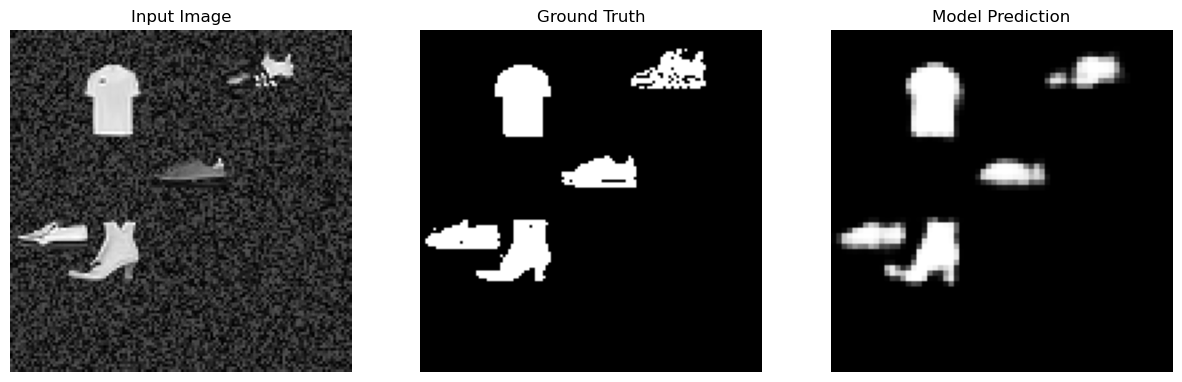

In [ ]:
# Part (c): visualize model output
idx = 0
image, target = dataset[idx]
with torch.no_grad():
    # add batch dimension then remove batch dimension after passing to model
    prediction = model(image.unsqueeze(0)).squeeze(0) 

plt.figure(figsize=(15, 6))
plt.subplot(131)
plt.imshow(image.squeeze(0).numpy(), 'gray') # remove color channel dimension with .squeeze(0)
plt.axis(False)
plt.title('Input Image')
plt.subplot(132)
plt.imshow(target.squeeze(0).numpy(), 'gray')
plt.axis(False)
plt.title('Ground Truth')
plt.subplot(133)
plt.imshow(prediction.squeeze(0).numpy(), 'gray')
plt.axis(False)
plt.title('Model Prediction')


# Improving Model Generalization
Thus far, we have discussed the need for machine learning models to generalize to unseen validation or testing data after being fit to provided training data. We have only considered how parameters of the learning algorithm, e.g. learning rate, weight decay, momentum, or more recently how the model architecture, e.g. number of layers, width of layers, choice of pooling, etc., may be selected or tuned to search for improved model generalization. None of these changes are inherently aimed at improving generalization, but rather design choices we may iterate in hopes of gains in validation/testing performance. Next, we consider two techniques and one more common deep learning layer that help with generalization.

## Image Augmentations
One potential bottleneck that degrades model generalization is the availability of data. Deep learning models learn by recognizing common patterns in training data. The hope is that these patterns translate well to new, unseen data. With scarce data, this is quite challenging while abundant data helps capture the general distribution of information the model is being trained and thus evaluated on.

A highly popular technique for improving model generalization and robustness is the use of **augmentations**, more specifically **image augmentations** for training CNNs and other vision models. Image augmentations apply simple transformations to input data that do not affect the underlying ground-truth of the data. For example, for the task of image classification, flipping an image of a cat will not change that the image is of a cat. However, shuffling all the pixels randomly makes the image of a cat indiscernible to humans and thus not a useful image augmentation. Some common image augmentations are described below.

* **Random flipping**: Typically, this is a horizontal (left-right) flip of an image with some probability, e.g. 0.5. Some applications, for example recognizing digits or text, cannot use random flipping.
* **Random Cropping**: For some range of cropping sizes and aspect ratios, pick a random rectangle of image coordinates to crop out.
* **Blurring**: Various blurring filters may be applied to an image to distort edges or smooth information.
* **Contrast/Color Adjustments**: Many different adjustments may be made to the brightness, hue, contrast, or saturation, as well as different color adjustments, e.g. gamma correction, to change the color appearance of images.
* **Affine Transformations**: Any [translation, rotation, or shearing](https://www.mathworks.com/discovery/affine-transformation.html) of an image may be represented by an affine transformation matrix.
* **...and plenty more**: [See the PyTorch and torchvision transformations here](https://pytorch.org/vision/main/transforms.html).

Example image augmentations are depicted below.

<div>
    <center><img src="augmentation-examples.jpg" width="800"></center>
</div>

## Dropout
Deep learning models are often seen as over-parameterized, meaning that they have many more parameters than example data to train on. Informally speaking, this can give models a tendency to **overfit** to training data and memorize patterns in the data. The technique of **dropout** seeks to remove this dependency on memorization during training. For a given probability $p\in(0, 1)$, a dropout layer will mute or set to zero each entry in an input features map with probability $p$. Dropout seeks to reduce a model's dependency on very specific features for certain training examples and encourage more robust and generalizable feature representations.

<div>
    <center><img src="dropout-example.png" width="800"></center>
</div>

## Batch Norm
The activations following non-linearities in a deep net are not guaranteed to follow any "nice" distribution of values. For example, a deep net with ReLU activations will only produce positive values that may be any arbitrarily large positive number. **Batch normalization** layers attempt to rectify the distribution of activations by applying a standard normalization. During training, the activations of a given layer $Z\in\mathbb{R}^{N\times C\times H \times W}$ for $N$ examples in a batch with $C$ feature channels each of size $H\times W$ are normalized by computing the per-channel mean and standard deviation within the batch. For feature channel $c$, let the mean and standard deviation be denoted by $\mu_c$ and $\sigma_c$. We apply [batch normalization](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html) elementwise for feature map $Z_c\in\mathbb{R}^{N\times H\times W}$ by

$$
\textrm{BatchNorm}(Z_c) = \frac{Z_c-\mu_c}{\sigma_c}*\gamma_c+\beta_c.
$$

Above, $\gamma_c$ and $\beta_c$ are learnable parameters for channel $c$ to skew the mean and standard deviation of the activations from a standard normal distribution as necessary during training. Thus, each channel has its own parameters and a batch norm layer will have $2C$ learnable parameters. During training, the model uses the batch mean and standard deviation to apply the normalization while also keeping running statistics for the dataset mean and standard deviation. At evaluation/testing time, we use the overall running statistics instead of the mini-batch statistics, which are susceptible to stochastic batch effects. In practice, batch norma has been shown to give strong improvements to CNNs and other deep net architectures, in particular for natural image datasets.

### The ``.eval()`` and ``.train()`` Methods
The above dropout and batch norm layers clearly have behavior that is unique to training versus model evaluation and testing. For example, we do not want to randomly remove a fraction of features at a particular layer when evaluating our model; this is only helpful during model training. The ``nn.Module`` class provides a simple interface to toggle our deep nets between training and evaluation model. For a deep net model named ``my_model``, we may set all layers into training mode, e.g. activate dropout, by calling ``my_model.train()``. Then, when evaluating the model, we simply call ``my_model.eval()``. We alternate between these modes when training by backpropagation and when evaluating a deep net.